<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/rapids-cuDF-cuml-01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to cuML

In [4]:
!nvidia-smi

Wed Sep 11 19:48:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
!wget -nc https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
!bash rapids-colab.sh

import sys, os

sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

--2019-09-11 19:48:17--  https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rapidsai/notebooks-contrib/raw/master/utils/rapids-colab.sh [following]
--2019-09-11 19:48:17--  https://github.com/rapidsai/notebooks-contrib/raw/master/utils/rapids-colab.sh
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rapidsai/notebooks-contrib/master/utils/rapids-colab.sh [following]
--2019-09-11 19:48:17--  https://raw.githubusercontent.com/rapidsai/notebooks-contrib/master/utils/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.co

### Required Imports

In [6]:
import cudf
import pandas as pd
import numpy as np
import math
from math import cos, sin, asin, sqrt, pi, atan2
from numba import cuda
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

print('NumPy Version:', np.__version__)

NumPy Version: 1.16.5


### Scikit-Learn

Linear Regression

y = 2.0 * x + 1.0

In [15]:

n_rows = 1000000
w = 2.0
x = np.random.normal(loc=0, scale=2, size=(n_rows,))
b = 1.0
y = w * x + b


noise = np.random.normal(loc=0, scale=2, size=(n_rows,))
y_noisy = y + noise

y_noisy[:5]

array([3.1331545 , 6.42272191, 3.24798057, 3.45747926, 4.97974749])

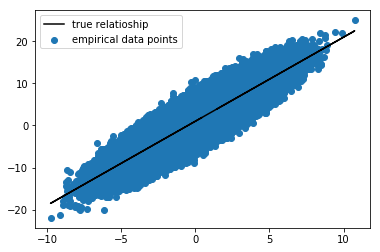

In [17]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relatioship')
plt.legend()